In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/컴퓨터비전/NetVLAD')

!pip install faiss-gpu

     |████████████████████████████████| 89.7 MB 8.1 kB/s 


In [3]:
cd /content/drive/My Drive/컴퓨터비전/NetVLAD

/content/drive/My Drive/컴퓨터비전/NetVLAD


In [4]:
ls -al

total 85338
-rw------- 1 root root    29840 Aug  7 23:32 berlin.mat
drwx------ 2 root root     4096 Sep 26 10:01 ckpt/
-rw------- 1 root root    27934 Nov  8 04:20 NetVLAD_base_code.ipynb
-rw------- 1 root root 87315062 Sep 27 01:37 pittsburgh_checkpoint.pth.tar
drwx------ 2 root root     4096 Sep 26 08:20 Query_resized/
drwx------ 2 root root     4096 Sep 26 08:20 Reference_resized/


In [5]:
!nvidia-smi

Mon Nov  8 04:21:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision

from torchvision.models import resnet18,vgg16

torch.manual_seed(777)

In [7]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=12, dim=128, alpha=100.0,normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=False)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )

    def forward(self, x):

        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        vlad = torch.zeros([N, self.num_clusters, C], dtype=x.dtype, layout=x.layout, device=x.device)
        for C in range(self.num_clusters): # slower than non-looped, but lower memory usage 
            residual = x_flatten.unsqueeze(0).permute(1, 0, 2, 3) - \
                    self.centroids[C:C+1, :].expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
            residual *= soft_assign[:,C:C+1,:].unsqueeze(2)
            vlad[:,C:C+1,:] = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [8]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
# VGG 16
encoder = vgg16(pretrained=True)
layers = list(encoder.features.children())[:-2]

for l in layers[:-5]: 
    for p in l.parameters():
        p.requires_grad = False

model = nn.Module() 

encoder = nn.Sequential(*layers)
model.add_module('encoder', encoder)

dim = list(encoder.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=16, dim=dim)
model.add_module('pool', net_vlad)

model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
# Pretrained Model Load(Pittsburgh 30k)
load_model = torch.load('./pittsburgh_checkpoint.pth.tar')
model.load_state_dict(load_model['state_dict'])

<All keys matched successfully>

In [12]:
import torch.utils.data as data
import torchvision.transforms as transforms

from random import choice
from os.path import join, exists
from collections import namedtuple
from scipy.io import loadmat
from PIL import Image
from sklearn.neighbors import NearestNeighbors

root_dir = '/content/drive/My Drive/컴퓨터비전/NetVLAD'

def parse_dbStruct(path):
    mat = loadmat(path)

    matStruct = mat['dbStruct'][0]

    dataset = 'dataset'

    whichSet = 'VPR'

    dbImage = matStruct[0]
    locDb = matStruct[1]

    qImage = matStruct[2]
    locQ = matStruct[3]

    numDb = matStruct[4].item()
    numQ = matStruct[5].item()

    posDistThr = matStruct[6].item()
    posDistSqThr = matStruct[7].item()

    return dbStruct(whichSet, dataset, dbImage, locDb, qImage, 
            locQ, numDb, numQ, posDistThr, 
            posDistSqThr)
  
dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset',
  'dbImage', 'locDb', 'qImage', 'locQ', 'numDb', 'numQ',
  'posDistThr', 'posDistSqThr'])
  
class BerlinDataset(data.Dataset) :
  
  def __init__(self,condition='train') :
    self.dbStruct = parse_dbStruct('/content/drive/My Drive/컴퓨터비전/NetVLAD/berlin.mat')
    self.input_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
      ])
    
    self.condition = condition

    if self.condition == 'train' :
      self.images = [join(root_dir, dbIm.replace(' ','')) for dbIm in self.dbStruct.dbImage]
    elif self.condition == 'test' :
      self.images = [join(root_dir, qIm.replace(' ','')) for qIm in self.dbStruct.qImage]
    else :
      self.images = [join(root_dir, dbIm.replace(' ','')) for dbIm in self.dbStruct.dbImage]
    
    self.positives = None
    self.distances = None

    self.getPositives()
  
  def __getitem__(self, index):

      if self.condition == 'train' :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        pos_list = self.positives[index].tolist()
        pos_list.remove(index)
        pos_index = self.positives[index][np.random.randint(0,len(self.positives[index]))]
        pos_img = Image.open(self.images[pos_index])
        pos_img = self.input_transform(pos_img)

        pos_list = pos_list + [index]
        neg_index = choice([i for i in range(len(self.images)) if i not in pos_list])
        neg_img = Image.open(self.images[neg_index])
        neg_img = self.input_transform(neg_img)

        img = torch.stack([img,pos_img,neg_img],dim=0)
        label = torch.Tensor([0, 0, 1])

        return img, label

      elif self.condition == 'test' :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        return img
      
      else :
        img = Image.open(self.images[index])
        img = self.input_transform(img)

        return img


  def __len__(self):
      return len(self.images)

  def getPositives(self):
      # positives for evaluation are those within trivial threshold range
      #fit NN to find them, search by radius
      if  self.condition == 'train' :
          knn = NearestNeighbors(n_jobs=1)
          knn.fit(self.dbStruct.locDb)

          self.distances, self.positives = knn.radius_neighbors(self.dbStruct.locDb,radius=self.dbStruct.posDistThr)
      else :
          knn = NearestNeighbors(n_jobs=1)
          knn.fit(self.dbStruct.locDb)

          self.distances, self.positives = knn.radius_neighbors(self.dbStruct.locQ,
                  radius=self.dbStruct.posDistThr)
      
      return self.positives

In [13]:
train_dataset = BerlinDataset(condition="train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=True,num_workers=0)   

In [14]:
epochs = 2
global_batch_size = 8
lr = 0.00001
momentum = 0.9
weightDecay = 0.001
losses = AverageMeter()
best_loss = 100.0
margin = 0.1 

criterion = nn.TripletMarginLoss(margin=margin**0.5, p=2, reduction='sum').cuda()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum, weight_decay=weightDecay)

model.train()

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_loader) :
    output_train = model.encoder(train_image.squeeze().cuda())
    output_train = model.pool(output_train)
    triplet_loss = criterion(output_train[0].reshape(1,-1),output_train[1].reshape(1,-1),output_train[2].reshape(1,-1))

    if batch_idx == 0 :
      optimizer.zero_grad()

    triplet_loss.backward(retain_graph=True)
    losses.update(triplet_loss.item())

    if (batch_idx +1) % global_batch_size == 0 :
      for name, p in model.named_parameters():
        if p.requires_grad:
          p.grad /= global_batch_size
    
        optimizer.step()
        optimizer.zero_grad()

    if batch_idx % 20 == 0 and batch_idx != 0:
      print('epoch : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,batch_idx,losses.avg))
  
  if best_loss > losses.avg :
    best_save_name = 'best_model.pt'
    best_path = F"./ckpt/{best_save_name}" 
    torch.save(model.state_dict(), best_path)
    
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"./ckpt/{model_save_name}" 
  torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 0, batch_idx  : 20, triplet_loss : 0.14831309659140451
epoch : 0, batch_idx  : 40, triplet_loss : 0.15549978250410498
epoch : 0, batch_idx  : 60, triplet_loss : 0.15815835604902173
epoch : 0, batch_idx  : 80, triplet_loss : 0.15316610203848946
epoch : 0, batch_idx  : 100, triplet_loss : 0.15087558432380752
epoch : 0, batch_idx  : 120, triplet_loss : 0.16050833759229044
epoch : 0, batch_idx  : 140, triplet_loss : 0.15777137558510962
epoch : 0, batch_idx  : 160, triplet_loss : 0.15601659376428734
epoch : 0, batch_idx  : 180, triplet_loss : 0.1490594856646838
epoch : 0, batch_idx  : 200, triplet_loss : 0.14803628215742348
epoch : 0, batch_idx  : 220, triplet_loss : 0.14674025450356945
epoch : 0, batch_idx  : 240, triplet_loss : 0.14425784497834834
epoch : 0, batch_idx  : 260, triplet_loss : 0.1432907286731676
epoch : 0, batch_idx  : 280, triplet_loss : 0.14373122627624837
epoch : 0, batch_idx  : 300, triplet_loss : 0.1455231192104048
epoch : 1, batch_idx  : 20, triplet_loss : 0.14


KeyboardInterrupt



In [15]:
from tqdm import tqdm

cluster_dataset = BerlinDataset(condition="cluster")
cluster_loader = torch.utils.data.DataLoader(cluster_dataset, batch_size=1,shuffle=False,num_workers=0) 

train_feature_list = list()

model.eval()

with torch.no_grad():
  for batch_idx, train_image in tqdm(enumerate(cluster_loader)) :
    output_train = model.encoder(train_image.cuda())
    output_train = model.pool(output_train)
    train_feature_list.append(output_train.squeeze().detach().cpu().numpy())

train_feature_list = np.array(train_feature_list)

314it [00:47,  6.63it/s]


In [16]:
test_dataset = BerlinDataset(condition="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False,num_workers=0)   

In [17]:
test_feature_list = list()

with torch.no_grad():
  for batch_idx, test_image in tqdm(enumerate(test_loader)) :
    output_test = model.encoder(test_image.cuda())
    output_test = model.pool(output_test)
    test_feature_list.append(output_test.squeeze().detach().cpu().numpy())

test_feature_list = np.array(test_feature_list)

280it [01:42,  2.73it/s]


In [25]:
import faiss

n_values = [1,5,10,20]

faiss_index = faiss.IndexFlatL2(train_feature_list.shape[1])
faiss_index.add(train_feature_list)

_, predictions = faiss_index.search(test_feature_list, max(n_values))

# for each query get those within threshold distance
gt = BerlinDataset(condition="test").getPositives()

correct_at_n = np.zeros(len(n_values))
#TODO can we do this on the matrix in one go?
for qIx, pred in enumerate(predictions):
    for i,n in enumerate(n_values):
        # if in top N then also in top NN, where NN > N
        if np.any(np.in1d(pred[:n], gt[qIx])):
            correct_at_n[i:] += 1
            break

recall_at_n = correct_at_n / BerlinDataset(condition="test").dbStruct.numQ

recalls = {} #make dict for output
for i,n in enumerate(n_values):
    recalls[n] = recall_at_n[i]
    print("====> Recall@{}: {:.4f}".format(n, recall_at_n[i]))

====> Recall@1: 0.3929
====> Recall@5: 0.5857
====> Recall@10: 0.6536
====> Recall@20: 0.7857


In [26]:
input_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
      ])

plot_dbStruct = parse_dbStruct('/content/drive/My Drive/컴퓨터비전/NetVLAD/berlin.mat')

db_images = [join(root_dir, dbIm.replace(' ','')) for dbIm in plot_dbStruct.dbImage]
q_images = [join(root_dir, qIm.replace(' ','')) for qIm in plot_dbStruct.qImage]

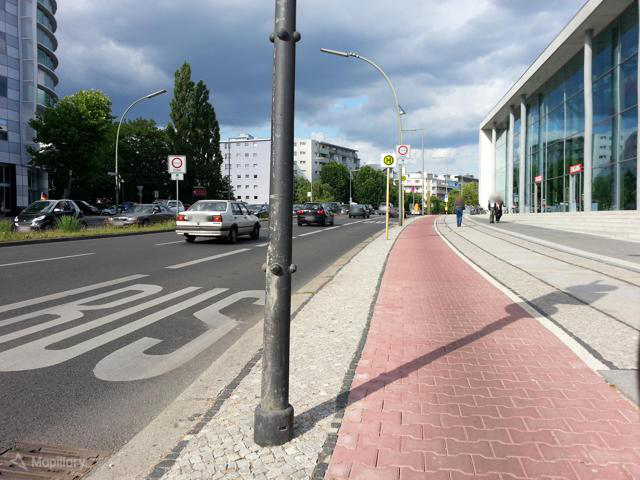

In [54]:
from IPython.display import display

index = 5

q_img = Image.open(q_images[index])
display(q_img)
q_img = input_transform(q_img)

In [55]:
output_test = model.encoder(q_img.unsqueeze(dim=0).cuda())
output_test = model.pool(output_test)
query_feature = output_test.squeeze().detach().cpu().numpy()

In [56]:
_, predictions = faiss_index.search(query_feature.reshape(1,-1), 5)

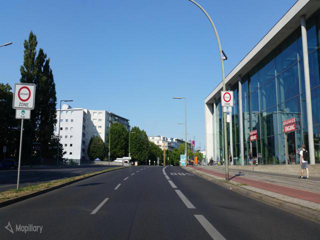

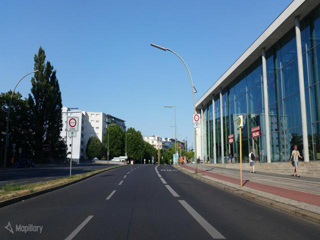

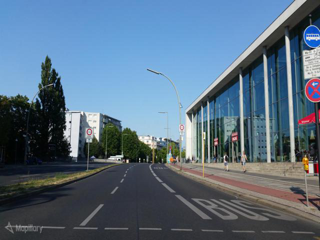

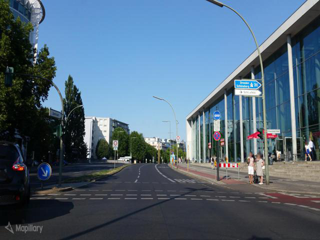

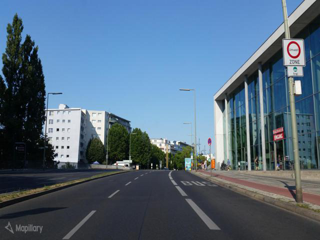

In [59]:
for idx in predictions[0]:
  db_img = Image.open(db_images[idx])
  db_img = db_img.resize((int(db_img.width / 2), int(db_img.height / 2)))
  display(db_img)
  print("\n")